# Noah Wanless and Apala Mandal

In [1]:
import pandas as pd
df = pd.read_csv("Traffic_Crashes.csv")

/var/folders/8t/y5v94x215r973w80szwrht8r0000gq/T/ipykernel_2363/939103122.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Traffic_Crashes.csv")


**Goal**

Our purpose here was to look at all the crashes in the chicago dataset that involve bikes or pedestrains and from there attempt to predict the injury level of that accident.\
The goal for the use of this model would be to although city officals to learn what types of factors can cause dangerous accidents so those factors can be midigated for the improved safety of the city.

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

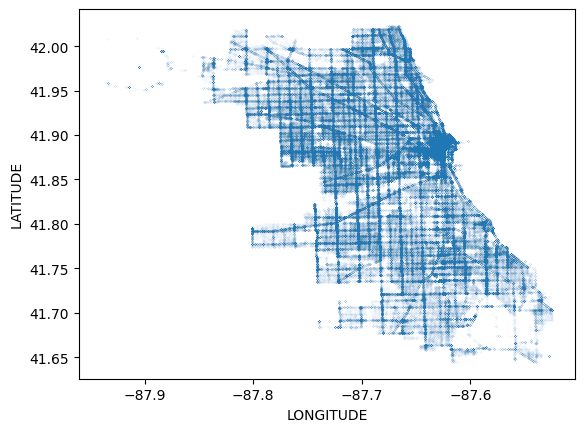

In [2]:
df[(df.LONGITUDE<-60) & (df.LATITUDE>30)].plot.scatter(x='LONGITUDE',y='LATITUDE',s=.00005) #for fun, look its chicago!

As some fun motivation we display all the locations of the crashes within this dataset on a map that shows the chicago area.

Data like this can help show officals locations of concern involing crashes along

In [3]:
df['MOST_SEVERE_INJURY'].value_counts()

MOST_SEVERE_INJURY
NO INDICATION OF INJURY     845724
NONINCAPACITATING INJURY     78890
REPORTED, NOT EVIDENT        44928
INCAPACITATING INJURY        16252
FATAL                         1049
Name: count, dtype: int64

**Labels**
Above is displayed all the possible catagories that the target may fall into, this also demonstrates how imbalanced the dataset is.\
To fix this we are going to do two things:\
A) We are going to remove the 'reported, not evident' label, so every row with this as its label will be removed. This is to 1 make the dataset smaller, and 2 because, as the label indicates, we are unsure what the actual injury is, it is not helpful to us.\
B) We are going to combine labels, so catagories of 'NO INDICATION OF INJURY' and 'NONINCAPACITATING INJURY' are going to be combined into one label, '0' (or minor injuries)/
While 'INCAPACITATING INJURY' and 'FATAL' labels are going to be combined into label '1' (or serious injuries)

In [4]:
df.isna().sum() #this one has no nans which is nice

CRASH_RECORD_ID                       0
CRASH_DATE_EST_I                 916993
CRASH_DATE                            0
POSTED_SPEED_LIMIT                    0
TRAFFIC_CONTROL_DEVICE                0
DEVICE_CONDITION                      0
WEATHER_CONDITION                     0
LIGHTING_CONDITION                    0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
LANE_CNT                         789970
ALIGNMENT                             0
ROADWAY_SURFACE_COND                  0
ROAD_DEFECT                           0
REPORT_TYPE                       32462
CRASH_TYPE                            0
INTERSECTION_RELATED_I           761738
NOT_RIGHT_OF_WAY_I               944484
HIT_AND_RUN_I                    678690
DAMAGE                                0
DATE_POLICE_NOTIFIED                  0
PRIM_CONTRIBUTORY_CAUSE               0
SEC_CONTRIBUTORY_CAUSE                0
STREET_NO                             0
STREET_DIRECTION                      4


**NaN's**
Above is displayed the counts of nans within each column for all columns of the data.\
If one compares these values with those of the numerical features we use below, you will find that none of the numerical features we use contain NaN's.\
(And while some of the catagorical features we use do, the encoders that encode that information will automatically handle those NaN's for us).

In [5]:
new_df = df.dropna(subset=['MOST_SEVERE_INJURY']) #so we only have data that has a most_server_injury
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

df_pedestrains = df[df['FIRST_CRASH_TYPE'].isin(['PEDESTRIAN','PEDALCYCLIST'])] #this is so it is only the people involed in a car crash with a bike/pedestrian

df_pedestrains = df_pedestrains[df_pedestrains['MOST_SEVERE_INJURY'] != 'REPORTED, NOT EVIDENT'] #removes all rows with this value

encoder = OrdinalEncoder(categories = [df_pedestrains['MOST_SEVERE_INJURY'].unique()]) #sets up encoder for the target labels

df_pedestrains['MOST_SEVERE_INJURY'] = encoder.fit_transform(df_pedestrains[['MOST_SEVERE_INJURY']]) #this is so our labels vec is encoded correctly, 0,1,2,3,4,5 etc 

mapping = {0:0,1:0,2:1,3:1}


df_pedestrains['MOST_SEVERE_INJURY'] = df_pedestrains['MOST_SEVERE_INJURY'].replace(mapping)

y = df_pedestrains['MOST_SEVERE_INJURY']
X = df_pedestrains.drop('MOST_SEVERE_INJURY',axis=1)


**Preprocessing**

This is were we are doing the Preprocessing of our data before we run the model.\
First we remove all rows that do not have a pedestrian of a cyclist involved.\
Then we remove all rows whose 'MOST_SEVERE_INJURY' label was 'REPORTED, NOT EVIDENT' (as we do not want these, see explaination above).\
Next we set up the encoder for the target features with the unique values that column takes on.\
Then we map together the 1 and 2nd labels into one, and the same with the 3rd and 4th labels.\
This is so the problem we are dealing with is now a binary classifier, a much easier problem. Additionally this combining of labels will help less the imbalance of the dataset so that it is more managable as seen by the value counts below which is a much better ratio then it was before

In [6]:

y.value_counts()

MOST_SEVERE_INJURY
0.0    25883
1.0     8082
Name: count, dtype: int64

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [8]:

numeric_features = ['POSTED_SPEED_LIMIT','CRASH_DAY_OF_WEEK']
ordinal_features = ['LIGHTING_CONDITION','ROADWAY_SURFACE_COND','DAMAGE']
oneHot_features = ['WEATHER_CONDITION','ROAD_DEFECT']

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline #pipeline stuff
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

numeric_processor=Pipeline(steps = [
    ('scaler',StandardScaler())
    ])
categorical_processor=Pipeline(steps = [
    ('encoder',OneHotEncoder(handle_unknown='ignore',min_frequency=.05)) #the ignore, encodes it to [0,0,0] all zeros, and does this for all nan values
    ])
ordinal_processor = Pipeline(steps=[
    ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1,min_frequency=.05))
])
feature_processor = ColumnTransformer(transformers = [
    ('num',numeric_processor,numeric_features),
    ('cat',categorical_processor,oneHot_features),
    ('ordinal',ordinal_processor,ordinal_features)],
    remainder='drop' 
    )


**The Model itself**

Above we have the Model itself, a Decision tree with polynomial features, a scaler for numerical features along with encoders for the nonnumerical features.
this is the processor, with encoders and polynomial features

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TunedThresholdClassifierCV


In [10]:
#NOW WE WILL TRY A DECISION TREE
from sklearn.tree import DecisionTreeClassifier
pipe_clf = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('ploy_features',PolynomialFeatures()),
    ('clf',DecisionTreeClassifier())
    ])
pipe_clf

,steps,"[('feature_processor', ...), ('ploy_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Grid Search**

Now we are going to find the best parameters for the model using a grid search.\
It must be noted that we are using the 'average_precision' metric for the scoring of the grid search beacuse later on we will change and tune the threshold of the model, so we can not use a metric here that will rely on the threshold.

In [11]:
param_grid={
    'ploy_features__degree':range(1,4),
    'clf__max_depth':range(1,5),
    'clf__max_leaf_nodes':[None,3,5,10],
}
grid = GridSearchCV(pipe_clf,
                          param_grid,
                          cv=5,
                          scoring='average_precision',
                          verbose=1,
                           n_jobs=-1
                         )
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'clf__max_depth': range(1, 5), 'clf__max_leaf_nodes': [None, 3, ...], 'ploy_features__degree': range(1, 4)}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


In [12]:
def f1_tuned_scorer(y_test,y_test_pred):
    mat = confusion_matrix(y_test,y_test_pred)
    tn = mat[0][0]
    fn = mat[1][0]
    fp = mat[0][1]
    tp = mat[1][1]
    value = (2*tp) / ( (2*tp) + fn + 500* fp )
    return value 
from sklearn.metrics import make_scorer

f1_tuned = make_scorer(f1_tuned_scorer)

In [13]:
tuned_pipe = TunedThresholdClassifierCV(estimator=grid.best_estimator_, 
                                        scoring=f1_tuned, #uses a combo of recall and precision, tries to max both of them=
                                        thresholds=300,
                                        n_jobs=-1)
tuned_pipe.fit(X_train,y_train)

,estimator,Pipeline(step...ax_depth=4))])
,scoring,make_scorer(f...hod='predict')
,response_method,'auto'
,thresholds,300
,cv,None
,refit,True
,n_jobs,-1
,random_state,None
,store_cv_results,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'


**Theshold Tuning**

Now we are tuning the threshold of the model. We are doing this because the dataset is still imbalanced so we want to tune the threshold to account for this. We are using a custom scoring metric because we want a metric that relies both on recall and precsion (such as f1). However f1 using both recall and precision equally. What we want is to give a ratio of priority to the precision metric, while still using recall(because if we were to use the base recaprecisionll metric, the model would simply never predict the second label or '1').\

So we made a custom metric that uses the f1 formula but adds a coefficent to the 'fp' term so that it works to minimize the fp term (or the metric that precision tries to minimize) more so then the 'fn' term (or the metric that recall tries to minimize), while still minimizing both.

This function is used to see how different thresholds preform and the best one is chosen.\
And now we go on to the performance of the model.

In [14]:

y_test_pred = tuned_pipe.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_test_pred))
print("Accuracy:")
print(accuracy_score(y_test,y_test_pred))


Confusion Matrix:
[[6207  273]
 [1893  119]]
Accuracy:
0.7449364107395196


**Model Performance**

The accuracy is decent although not ideal. However this is a trade off we were aware of because we wanted to make sure the model simply didnt stop predicting the second label (of the second column in the confusion matrix).\
So we took the hit in accuracy, but in return it meant the model gave some level of priority to predicting the second label.\

Now it may seem bad that the model over predicts major injuries (label '1') incorrectly more so then it does so correctly. However given the real worl uses of this its fine. If a model predicts that certain factors may increase the likelyhood of a crash resulting in major injurings incorrectly, we would rather have that then it not predicting this, and those factors/locations do end up being related to worse crashes. IE, better safe then sorry.



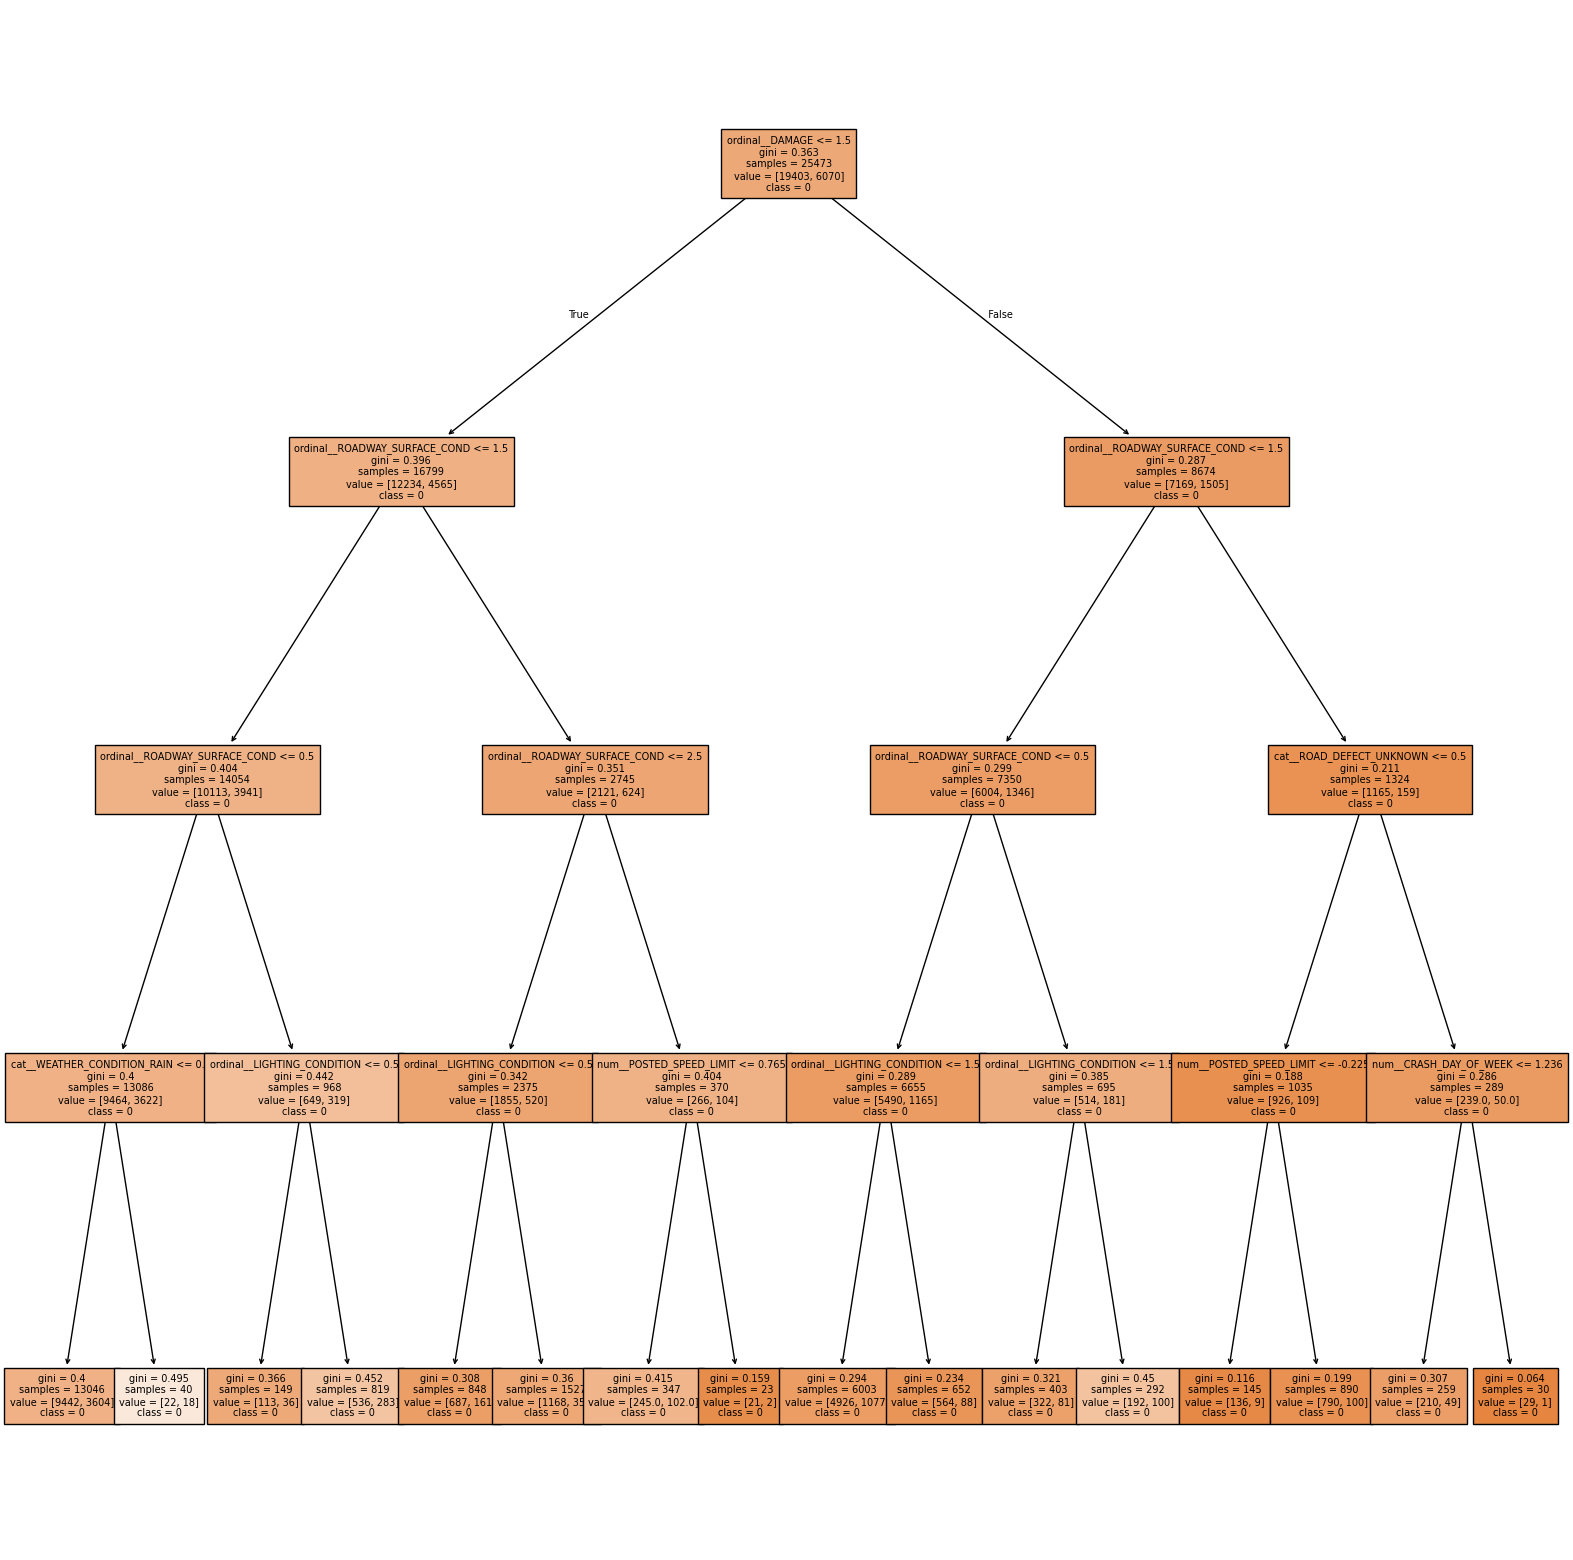

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
temp = tuned_pipe.estimator_
feature_name = temp['ploy_features'].get_feature_names_out(temp['feature_processor'].get_feature_names_out())

tree = temp['clf']
#plt.figure(figsize=(15,8))
plt.figure(figsize=(20, 20))
plot_tree(tree,
          feature_names= feature_name, #we will do this later
          class_names=['0','1'],
          filled=True,
          fontsize=7
         )
plt.show()

**Sanity Check**

Here are at the end a quick sanity check to make sure that the model behaves in a logic manner.

It makes sense that the model would consider the total damage that the crashe resulted in as the first feature to consider, then moving on to the combination of weather and lighting conditions and so forth. 
These all make sense, and the model is therefore seemingly, good.

Overall then, while the performance of the mode is not 'ideal' with a less then nice accuracy, and still persistant adversion to prediciting the second label of major crashes, it still seems to work well and seems to be worth while for offical use 

**A bit for fun!**

I am going to make up a fake car crash to see how it the would think would happen.


In [16]:
base_record = X_train.iloc[[2,2,]]

In [17]:
# some of the potential options you could pick:
base_record.iloc[0,3] = 40 #posted speed limit 
base_record.iloc[0,6] = "CLEAR" # WEATHER_CONDITION : SEVERE CROSS WIND GATE, CLEAR
base_record.iloc[0,7] = "DAWN" # LIGHTING_CONDITION:  DAWN, DAYLIGHT, DARKNESS, LIGHTED ROAD
base_record.iloc[0,12] = "WET" # ROADWAY_SURFACE_COND:  DRY, WET 
base_record.iloc[0,19] = "OVER $1,500" # DAMAGE: "$500 OR LESS", "$501 - $1,500", "OVER $1,500"
print("And after editing all the entires to make our own crash, this is what it gave us as a prediction!")
print(tuned_pipe.predict(base_record)[0])
print("Or we did not suffer fatal or incapacatiatings injuries!")

And after editing all the entires to make our own crash, this is what it gave us as a prediction!
0.0
Or we did not suffer fatal or incapacatiatings injuries!
